# UZOP - timski projekt
Hrvoje Molnar (0036534711)

Ana Francesca Stama (0036531912)

Luka Nestić (0036534914)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from pandas.api.types import is_numeric_dtype
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", module="sklearn")
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

Prije svega, replicirat ćemo rezultate polaznog članka. Počinjemo s čišćenjem dobivenih podataka.

# Predobrada podataka

In [43]:
df=pd.read_csv("CBWDB.csv")
df

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,T,F,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,T,M,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,T,M,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,T,F,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,T,F,2.3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,BPL,26.0,NaN,NaN,0.0,3.0,39.0,40.0,110.0,78.0,112.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1796,BPL,22.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1797,BPL,24.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798,BPL,24.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vidimo da u ciljnom stupcu LNH ima nedostajućih vrijednosti. Morat ćemo ukloniti takve točke jer njihova nadopuna nema smisla. Ne možemo u klasifikacijskom problemu mijenjati ciljne klase.

In [44]:
df_filtered=df[df["LNH"].isna()==False]
print("Nedostajuće vrijednosti po stupcima:")
print(df_filtered.isna().sum())
print("\nBroj redaka nakon filtriranja: ",len(df_filtered))

Nedostajuće vrijednosti po stupcima:
SEC             200
Age(years)        3
Height(cm)      128
Bgroup          367
Parity            0
ANC               0
Iwt(kg)          12
FWt(kg)          13
IBP_sys           4
IBP_dias          4
FBP_sys           6
FBP_dias          6
IHb(gm%)        103
FHb(gm%)        102
BS(RBS)         531
Term/Preterm    133
Sex              11
BWt(kg)           0
LNH               0
dtype: int64

Broj redaka nakon filtriranja:  1072


U datasetu vidimo da preko pola vrijednosti BS(RBS) nedostaje! Procjenjujemo da uklanjanjem redova s nepostojećim vrijednostima ove varijable možemo doći do približnog broja filtriranih podataka u članku (445) pa ćemo tako i postupiti. Usput ćemo ukloniti i točke s marginalnim vrijednostima: LNH vrijednosti 3 (pretila novorođenčad) i Sex u vrijednosti T. Takvih je podataka vrlo, vrlo malo pa brojem redova sigurno nećemo pasti ispod okvirnih 445 redaka dataframea.


In [45]:
df_filtered=df_filtered[(df_filtered["LNH"]!=3) & (df_filtered["Sex"]!="T") & (df_filtered["BS(RBS)"].isna()==False)] 

print(df_filtered.isna().sum())
print("Broj točaka: ",len(df_filtered))

SEC             35
Age(years)       0
Height(cm)       0
Bgroup          20
Parity           0
ANC              0
Iwt(kg)          0
FWt(kg)          0
IBP_sys          0
IBP_dias         0
FBP_sys          0
FBP_dias         0
IHb(gm%)         0
FHb(gm%)         0
BS(RBS)          0
Term/Preterm     2
Sex              1
BWt(kg)          0
LNH              0
dtype: int64
Broj točaka:  537


Sve NaN vrijednosti pripadaju kategoričkim varijablama. Pošto ih je relativno malo, zamijenit ćemo ih modom pripadajućeg stupca.

In [46]:
cat_cols=["SEC","Sex","Term/Preterm","Bgroup"]
for col in cat_cols:
    df_filtered[col]=df_filtered[col].fillna(df_filtered[col].mode()[0])

Prikažimo kutijaste dijagrame numeričkih varijabli!

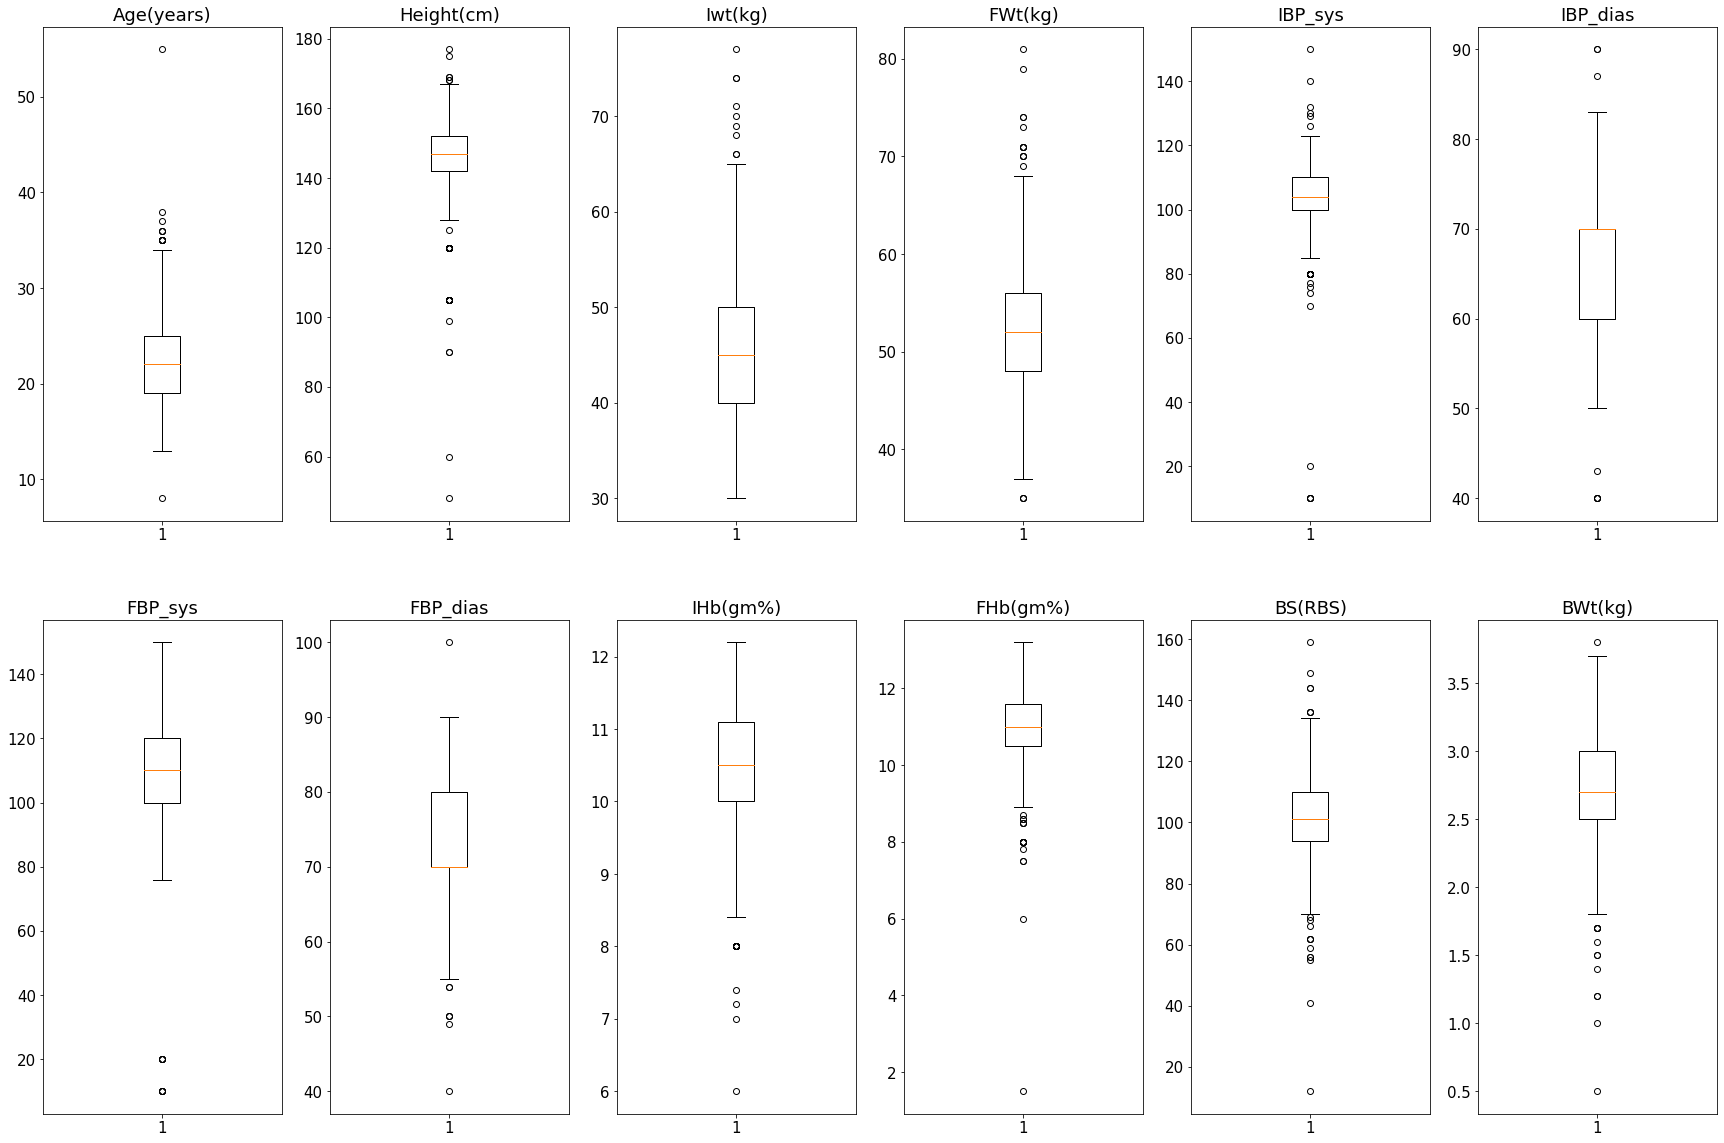

In [47]:
cols=["Age(years)","Height(cm)","Iwt(kg)","FWt(kg)","IBP_sys","IBP_dias","FBP_sys","FBP_dias","IHb(gm%)","FHb(gm%)","BS(RBS)","BWt(kg)"]
fig,ax=plt.subplots(2,6,figsize=(30,20))
i,j=0,0
for col in cols:
    ax[i,j].boxplot(df_filtered[col])
    ax[i,j].set_title(col)
    j+=1
    if j==6:
        i,j=i+1,0

df_checkpoint1 = df_filtered.copy()   

Vidljivo je puno stršećih uzoraka. Pošto je obrada podataka u članku vrlo šturo opisana, zasad ćemo ih zadržati. Njima ćemo se baviti kad na red dođe poboljšanje modela.

Za kraj, kategoričke značajke pretvaramo u numeričke, a numeričke normaliziramo. Nakon cijelog postupka, ostaje nam 537 uzoraka, nešto više nego u članku.

In [48]:
for col in df_filtered.columns:
    if col in cat_cols:
        df_filtered[col]=df_filtered[col].astype('category').cat.codes
    else:
        df_filtered[col]=(df_filtered[col]-df_filtered[col].min())/(df_filtered[col].max()-df_filtered[col].min())     
df_filtered.describe()  

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,0.711359,0.309838,0.755229,6.467412,0.060521,0.903786,0.340901,0.380212,0.671123,0.537803,0.700559,0.517070,0.707782,0.803769,0.609813,0.888268,0.527002,0.665115,0.802607
std,0.453553,0.094957,0.100271,2.706294,0.124312,0.224098,0.149586,0.150947,0.094770,0.158280,0.116935,0.131810,0.159504,0.085988,0.104271,0.315330,0.499736,0.128417,0.398402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.234043,0.728682,5.000000,0.000000,1.000000,0.212766,0.282609,0.642857,0.400000,0.642857,0.500000,0.645161,0.769231,0.557823,1.000000,0.000000,0.606061,1.000000
50%,1.000000,0.297872,0.767442,8.000000,0.000000,1.000000,0.319149,0.369565,0.671429,0.600000,0.714286,0.500000,0.725806,0.811966,0.605442,1.000000,1.000000,0.666667,1.000000
75%,1.000000,0.361702,0.806202,8.000000,0.000000,1.000000,0.425532,0.456522,0.714286,0.600000,0.785714,0.666667,0.822581,0.863248,0.666667,1.000000,1.000000,0.757576,1.000000
max,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Vizualizacija

Kako bismo dobili uvid u strukturu podataka te moguće probleme, provodimo analizu glavnih komponenti (PCA). PCA je tehnika za smanjenje dimenzionalnosti podataka koja pronalazi osi najveće varijabilnosti podataka te preslikava $n$-dimenzionalni prostor podataka u $k$-dimenzionalni, gdje $n>k$. Kao takva, vezana je uz varijance naših značajki.

In [49]:
#Pretvorba u ndarray i train-test podjela s uključenom stratifikacijom
X=df_filtered.drop(columns="LNH").to_numpy()
y=df_filtered["LNH"].to_numpy()

sorted_vars = dict(zip(np.array(df_filtered.drop(columns="LNH").columns), np.round(np.var(X,axis=0),3)))
sorted_vars = dict(sorted(sorted_vars.items(), key=lambda item: item[1], reverse=True))
print("Column variances:") 
sorted_vars


Column variances:


{'Bgroup': 7.31,
 'Sex': 0.249,
 'SEC': 0.205,
 'Term/Preterm': 0.099,
 'ANC': 0.05,
 'IBP_dias': 0.025,
 'IHb(gm%)': 0.025,
 'FWt(kg)': 0.023,
 'Iwt(kg)': 0.022,
 'FBP_dias': 0.017,
 'BWt(kg)': 0.016,
 'Parity': 0.015,
 'FBP_sys': 0.014,
 'BS(RBS)': 0.011,
 'Height(cm)': 0.01,
 'Age(years)': 0.009,
 'IBP_sys': 0.009,
 'FHb(gm%)': 0.007}

Vidimo da je $Var(\text{Bgroup})$ puno veća od ostalih. Pogledajmo kako izgledaju dvodimenzionalne PCA i t-SNE preslike podataka s i bez tog stupca.

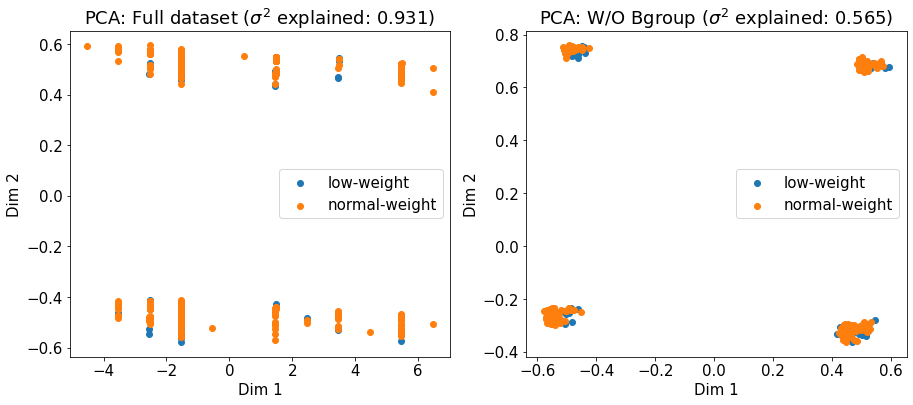

In [50]:
pca=PCA(n_components=2)
fig,ax=plt.subplots(1,2,figsize=(15,6))

X_pca1=pca.fit_transform(X)
ax[0].scatter(X_pca1[np.where(y==0)[0], 0], X_pca1[np.where(y==0)[0], 1], label="low-weight")
ax[0].scatter(X_pca1[np.where(y==1)[0], 0], X_pca1[np.where(y==1)[0], 1], label="normal-weight")
ax[0].set_title("PCA: Full dataset ($\sigma^2$ explained: {:.3f})".format(sum(pca.explained_variance_ratio_)))
ax[0].set_xlabel("Dim 1")
ax[0].set_ylabel("Dim 2")
ax[0].legend()

X_pca2=pca.fit_transform(np.delete(X,3,axis=1))
ax[1].scatter(X_pca2[np.where(y==0)[0], 0], X_pca2[np.where(y==0)[0], 1], label="low-weight")
ax[1].scatter(X_pca2[np.where(y==1)[0], 0], X_pca2[np.where(y==1)[0], 1], label="normal-weight")
ax[1].set_title("PCA: W/O Bgroup ($\sigma^2$ explained: {:.3f})".format(sum(pca.explained_variance_ratio_)))
ax[1].set_xlabel("Dim 1")
ax[1].set_ylabel("Dim 2")
ax[1].legend()

plt.show()

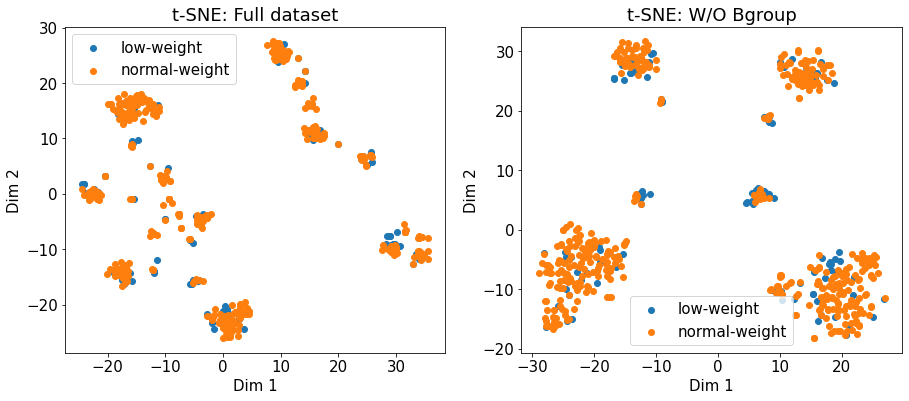

In [51]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
fig,ax=plt.subplots(1,2,figsize=(15,6))

X_tsne1=tsne.fit_transform(X)
ax[0].scatter(X_tsne1[np.where(y==0)[0], 0], X_tsne1[np.where(y==0)[0], 1], label="low-weight")
ax[0].scatter(X_tsne1[np.where(y==1)[0], 0], X_tsne1[np.where(y==1)[0], 1], label="normal-weight")
ax[0].set_title("t-SNE: Full dataset")
ax[0].set_xlabel("Dim 1")
ax[0].set_ylabel("Dim 2")
ax[0].legend()

X_tsne2=tsne.fit_transform(np.delete(X,3,axis=1))
ax[1].scatter(X_tsne2[np.where(y==0)[0], 0], X_tsne2[np.where(y==0)[0], 1], label="low-weight")
ax[1].scatter(X_tsne2[np.where(y==1)[0], 0], X_tsne2[np.where(y==1)[0], 1], label="normal-weight")
ax[1].set_title("t-SNE: W/O Bgroup")
ax[1].set_xlabel("Dim 1")
ax[1].set_ylabel("Dim 2")
ax[1].legend()

plt.show()

Ovdje imamo dva komentara. Prvo, klase nisu razdvojene ni na jednom grafu (micanje ostalih značajki s visokom varijancom to ne mijenja). To nam govori da će klasifikacija vrlo vjerojatno biti teška. Drugo, micanjem Bgroup stupca, objašnjenja varijanca u PCA postupku smanjena je za 40%! Vidimo da je Bgroup veliki faktor za opisivanje podataka. Međutim, sjećamo se da je bilo jako puno nedostajućih vrijednosti u polaznom datasetu (367/1072 redova kojima LNH nije NaN $\approx$ 34%). Također, korelacija između tog stupca i BWt(kg) je skoro zanemariva:

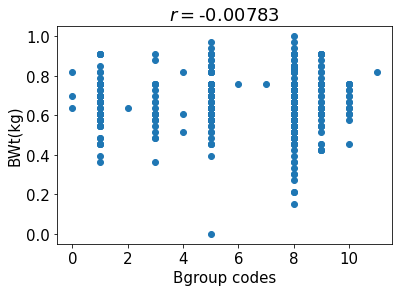

In [52]:
plt.scatter(df_filtered["Bgroup"],df_filtered["BWt(kg)"])
plt.xlabel("Bgroup codes")
plt.ylabel("BWt(kg)")
plt.title("$r=${:.5f}".format(np.corrcoef(df_filtered["Bgroup"],df_filtered["BWt(kg)"])[0,1]))
plt.show()

Iz problema velikog broja NaN vrijednosti i nepostojeće koreliranosti zaključujemo da se stupac Bgroup može ukloniti iz skupa podataka. To ćemo napraviti tek kasnije pri poboljšanju rezultata članka. Sad možemo krenuti u implementaciju modela!

# Modeli iz članka (GNB i RFC)

Kao u članku, 30% podataka ostavljamo za testiranje modela. Također koristimo stratifikaciju zbog iznimno nebalansiranog skupa podataka (>80% vrijednosti pripada klasi $y=1$). Za provjeru modela koristimo iste metrike kao u članku:

1. $Accuracy=\frac{TP+TN}{TP+FP+TN+FN}$

2. $Precision=\frac{TP}{TP+FP}$

3. $Recall=\frac{TP}{TP+FN}$

4. $F1=\frac{Precision \times Recall}{Precision + Recall}$

Koristi se više metrika zbog prijespomenute neuravnoteženosti klasa. Također, sve se metrike, osim $Accuracy$ mijenjaju kada zamijenimo pozitivnu i negativnu klasu ($TP$ u brojniku!). Stoga je bitno provjeriti metrike i za zamijenjene vrijednosti $y$.

In [53]:
#fja za provjeru metrika te ispis matrice konfuzije

def test_model(classifier, X_train, y_train, X_test, y_test, y_pred_train=None, y_pred_test=None):

    if classifier != None:
        classifier.fit(X_train,y_train)

        y_pred_train=classifier.predict(X_train)
        y_pred_test=classifier.predict(X_test)

    print("Train accuracy, precision, recall, F1: {:.3f} {:.3f} {:.3f} {:.3f}".format(accuracy_score(y_train,y_pred_train),precision_score(y_train,y_pred_train),recall_score(y_train,y_pred_train),f1_score(y_train,y_pred_train)))

    print("Test accuracy, precision, recall, F1: {:.3f} {:.3f} {:.3f} {:.3f}".format(accuracy_score(y_test,y_pred_test),precision_score(y_test,y_pred_test),recall_score(y_test,y_pred_test),f1_score(y_test,y_pred_test)))

    print("Confusion matrix: \n",confusion_matrix(y_test,y_pred_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
len(y_train),len(y_test)

(375, 162)

Prvi isprobani model u članku je Gaussian naive Bayes klasifikator.

In [54]:
gnb=GaussianNB()

test_model(gnb,X_train,y_train,X_test,y_test)
print("\n")
test_model(gnb,X_train,1-y_train,X_test,1-y_test)

Train accuracy, precision, recall, F1: 0.875 0.918 0.927 0.922
Test accuracy, precision, recall, F1: 0.809 0.884 0.877 0.880
Confusion matrix: 
 [[ 17  15]
 [ 16 114]]


Train accuracy, precision, recall, F1: 0.875 0.690 0.662 0.676
Test accuracy, precision, recall, F1: 0.809 0.515 0.531 0.523
Confusion matrix: 
 [[114  16]
 [ 15  17]]


Vidimo zadovoljavajuće iznose metrika u oba slučaja. To nam govori da smo na tragu! Isprobat ćemo još i Random Forest klasifikator. To je tzv ensemble model strojnog učenja, gdje se izlaz određuje "glasanjem" više jednostavnijih modela (ovdje, stabla odluke). Za razliku od prije, sad ćemo mijenjati parametre modela.

Uslijed ovoga, imali smo eureka trenutak: "**Čekaj malo**! U članku je kao značajka korištena težina bebe BWt(kg), a predviđena je klasa raspon težina (pothranjena, normalna i pretila beba). Nije li to... **Varanje**?! Kako bismo testirali ovo razmišljanje, napravit ćemo rubno jednostavan Random forest model (samo tri stabla s jednom podjelom listova) i vizualizirati da vidimo po kojem kriteriju nastaju čvorovi. Kao u članku, koristit ćemo Bootstraping za izradu stabala. Kriterij podjele bit će nam entropija.

Train accuracy, precision, recall, F1: 0.992 0.997 0.993 0.995
Test accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Confusion matrix: 
 [[ 32   0]
 [  0 130]]
Train accuracy, precision, recall, F1: 0.992 0.973 0.986 0.980
Test accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Confusion matrix: 
 [[130   0]
 [  0  32]]


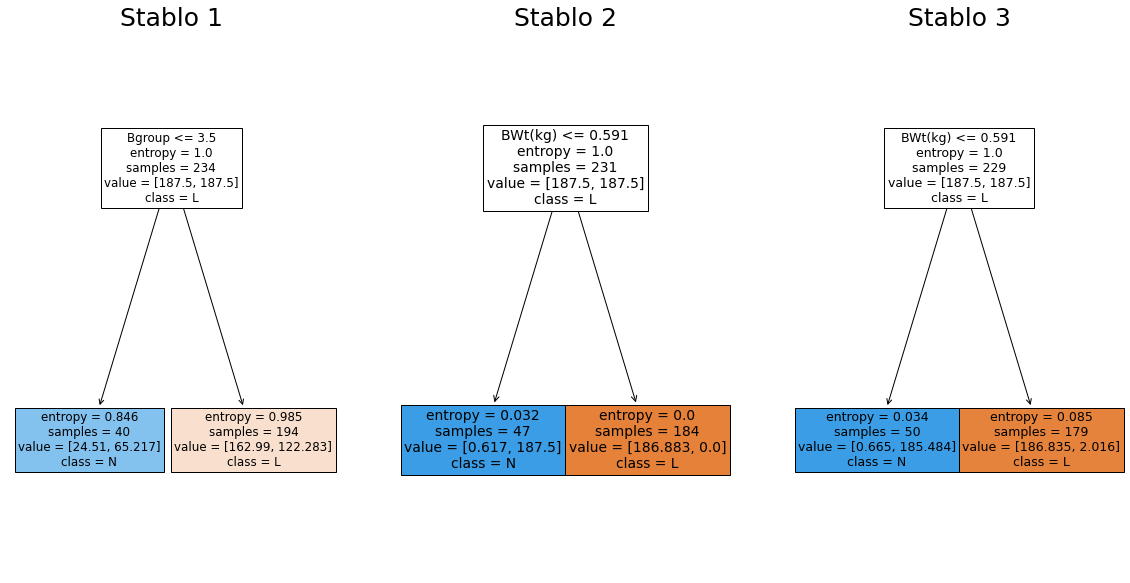

In [55]:
rfc=RandomForestClassifier(n_estimators=3,criterion="entropy",random_state=42,bootstrap=True,max_depth=1,class_weight="balanced_subsample")

test_model(rfc,X_train,y_train,X_test,y_test)
test_model(rfc,X_train,1-y_train,X_test,1-y_test)

fn=df_filtered.columns
cn=["L","N"]
fig,ax=plt.subplots(1,3,figsize=(20,10))

for i in range(3):
    tree.plot_tree(rfc.estimators_[i],feature_names=fn,class_names=cn,filled = True,ax=ax[i])
    ax[i].set_title('Stablo ' + str(i+1), fontsize = 25)

Znali smo! Dva od tri stabla dijele po istom kriteriju BWt(kg), čak je i granica ista! De facto, to je jedino stablo koje donosi odluku. Dobili smo savršeni klasifikator, baš kao u članku, isključivo na temelju težine bebe.

# Jesu li rezultati članka valjani?

Gornji zaključak upućuje na to da postupak u članku nije dobar. Ako su težinske kategorije bebe L (low-weight), N (normal-weight) i H (high-weight) jednoznačno određene rasponom masa koji se ne preklapaju, iz BWt(kg) jednoznačno se može odrediti izlazna klasa $y$. Pokušajmo pronaći te intervale za klase L i N.

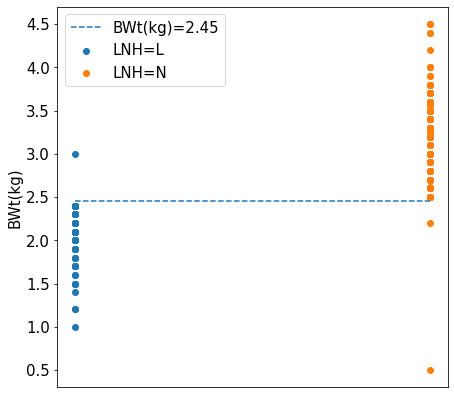

In [56]:
df_filtered=df[df["LNH"].isna()==False]
df_filtered=df_filtered[(df_filtered["LNH"]!=3) & (df_filtered["Sex"]!="T")] 

fig=plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
plt.scatter(np.ones(len(df_filtered[df_filtered["LNH"]==1])),df_filtered[df_filtered["LNH"]==1]["BWt(kg)"],label="LNH=L")
plt.scatter(np.ones(len(df_filtered[df_filtered["LNH"]==2]))*2,df_filtered[df_filtered["LNH"]==2]["BWt(kg)"],label="LNH=N")
plt.plot([1,2],[2.45,2.45],"--",label="BWt(kg)=2.45")
plt.xticks([])
plt.ylabel("BWt(kg)")
plt.legend()
plt.show()

Vidimo da u skupu podataka čak i ovdje imamo problem! Postoje bebe označene klasom N s manjom masom od beba označenih klasom L i obratno. Još jedan u nizu stvari koje treba popraviti...

# Dodatak predobradi podataka

Nastojat ćemo poboljšati rezultate uklanjanjem dvoznačnosti između varijabli _BWt(kg)_ i _LNH_ tako da uklonimo sve ratke čija je težina bebe veća ili jednaka odabranom thresholdu od 2.45, a klasificirana je kao pothranjena beba. Isto tako ćemo ukloniti i sve retke čija je težina bebe manja od thresholda, a klasificirana je kao beba normalne težine.

In [57]:
df = df_checkpoint1.copy()
thresh = 2.45
df = df.loc[((df["BWt(kg)"]<=thresh) & (df["LNH"]==1)) | 
                              ((df["BWt(kg)"]>thresh) & (df["LNH"]==2))]

Još jedna stvar koju ćemo napraviti je uklanjanje stršećih podataka. Stršeće podatke definirat ćemo kao one koji ne spadaju u $Z$-score interval $[-2.5,2.5]$ pojedinog stupca, što znači odbacivanje rubnih 1.2% podataka na rubovima razdiobe stupca.

In [58]:
print('Broj zapisa prije izbacivanja outliera:', len(df))
df_copy = df.copy()

for col in cols:
    z = np.abs(stats.zscore(df_copy[col]))
    outlier_indices = np.where(z > 2.5)[0]
    df_copy = df_copy.drop(df_copy.index[outlier_indices])

print('Broj zapisa nakon izbacivanja outliera:', len(df_copy))
df = df_copy.copy()

threshold_scaled = (thresh-df["BWt(kg)"].min())/(df["BWt(kg)"].max()-df["BWt(kg)"].min())
for col in df.columns:
    if col in cat_cols:
        df[col]=df[col].astype('category').cat.codes
    else:
        df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())


Broj zapisa prije izbacivanja outliera: 534
Broj zapisa nakon izbacivanja outliera: 422


In [59]:
for col in df.columns:
    if col in cat_cols:
        df[col]=df[col].astype('category').cat.codes
    else:
        df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())     
df.describe()  

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000
mean,0.729858,0.451185,0.469610,4.364929,0.056477,0.915482,0.457131,0.474097,0.543881,0.511561,0.521882,0.479397,0.582820,0.532671,0.515504,0.890995,0.518957,0.501066,0.817536
std,0.444560,0.185004,0.162068,1.604478,0.121175,0.214215,0.170571,0.199583,0.160930,0.218628,0.152705,0.203246,0.217480,0.173809,0.185678,0.312015,0.500234,0.189555,0.386685
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.300000,0.403509,4.000000,0.000000,1.000000,0.303030,0.310345,0.464286,0.303030,0.375000,0.444444,0.476190,0.446809,0.414286,1.000000,0.000000,0.400000,1.000000
50%,1.000000,0.450000,0.473684,5.000000,0.000000,1.000000,0.454545,0.448276,0.517857,0.606061,0.531250,0.444444,0.595238,0.531915,0.500000,1.000000,1.000000,0.500000,1.000000
75%,1.000000,0.550000,0.561404,5.000000,0.000000,1.000000,0.575758,0.586207,0.642857,0.606061,0.687500,0.722222,0.738095,0.659574,0.614286,1.000000,1.000000,0.650000,1.000000
max,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
X = df.drop(columns=['LNH', 'BWt(kg)', 'Bgroup']).to_numpy()
y = df['LNH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
len(y_train),len(y_test)

(295, 127)

# Grid Search

Jedna od stvari koje možemo napraviti kako bismo poboljšali modele (ne samo ove, nego i sve ostale koje ćemo implementirati) Grid Search, metoda pretraživanja unaprijed definiranih hiperparametara modela kroz sve moguće kombinacije kako bi se pronašao optimalan skup. Rezultat je najbolja konfiguracija hiperparametara prema unaprijed definiranoj metrici, koja je u našem slučaju $F1$, i to **kad je manjinska klasa y=1**. Razlog tomu su lošije performanse modela u ovom slučaju, po svim relevantnim metrikama.

In [77]:
# fja za pronalazak najboljih parametara
def test_parameters(classifier, X_train, y_train, params_search_space):
    criteria_metric = "f1"

    gs = GridSearchCV(estimator=classifier, 
                      param_grid=params_search_space,
                      scoring=(criteria_metric),
                      cv=10,
                      return_train_score=True)
    gs.fit(X_train, y_train)

    print(f"Best parameter set: {gs.best_params_}")

    if len(params_search_space) == 1:
        param_name = list(params_search_space.keys())[0]
        param_values = gs.cv_results_[f'param_{param_name}'].data
        mean_test_scores = gs.cv_results_['mean_test_score']
        mean_train_scores = gs.cv_results_['mean_train_score']

        plt.figure(figsize=(8, 6))
        plt.plot(param_values, mean_test_scores, label='Test Score', color='blue')
        plt.plot(param_values, mean_train_scores, label='Train Score', color='green')
        plt.xscale('log')
        plt.xlabel(f'{param_name}')
        plt.ylabel(f'{criteria_metric}')
        plt.title(f'{type(classifier).__name__} Grid Search Results')
        plt.legend()
        plt.grid(True)
        plt.show()

    return gs.best_params_

In [78]:
grid_search_mode = True

Sad ćemo to isprobati na Gaussian Naive Bayes i Random Forest modelima.

Best parameter set: {'var_smoothing': 0.22104546299710215}


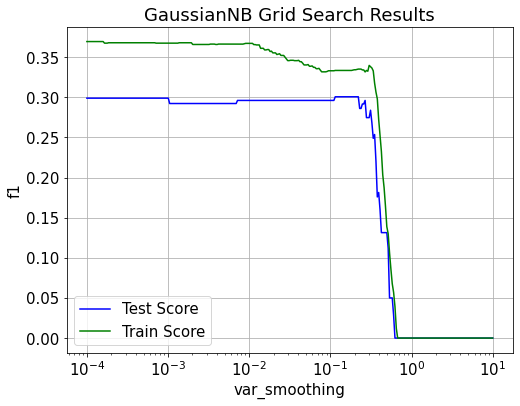

Train accuracy, precision, recall, F1: 0.810 0.849 0.934 0.889
Test accuracy, precision, recall, F1: 0.803 0.856 0.913 0.884
Confusion matrix: 
 [[ 7 16]
 [ 9 95]]


Train accuracy, precision, recall, F1: 0.810 0.467 0.259 0.333
Test accuracy, precision, recall, F1: 0.803 0.438 0.304 0.359
Confusion matrix: 
 [[95  9]
 [16  7]]


In [83]:
gnb=GaussianNB()

if grid_search_mode:
    gnb_best_params = test_parameters(gnb, X_train, 1-y_train, {
        'var_smoothing': np.logspace(1,-4, num=300)
    })
    gnb.set_params(**gnb_best_params)

test_model(gnb, X_train, y_train, X_test, y_test)
print("\n")
test_model(gnb,X_train,1-y_train,X_test,1-y_test)

In [85]:
rfc=RandomForestClassifier(n_estimators=101,criterion="entropy",random_state=42,bootstrap=True,max_depth=3,class_weight="balanced_subsample")

if grid_search_mode:
    rfc_best_params = test_parameters(rfc, X_train, 1-y_train, {
        'n_estimators': np.linspace(3, 120, 15, dtype=int).tolist(),
        'max_depth': np.linspace(2, 50, 6, dtype=int).tolist(),
    })
    rfc.set_params(**rfc_best_params)

test_model(rfc, X_train, y_train, X_test, y_test)
print("\n")
test_model(rfc,X_train,1-y_train,X_test,1-y_test)

Best parameter set: {'max_depth': 2, 'n_estimators': 44}
Train accuracy, precision, recall, F1: 0.807 0.900 0.859 0.879
Test accuracy, precision, recall, F1: 0.732 0.850 0.817 0.833
Confusion matrix: 
 [[ 8 15]
 [19 85]]


Train accuracy, precision, recall, F1: 0.807 0.477 0.574 0.521
Test accuracy, precision, recall, F1: 0.732 0.296 0.348 0.320
Confusion matrix: 
 [[85 19]
 [15  8]]


Vidljiv je pad performansi modela, pogotovo za invertirane labele. Slutnja o "namještanju" rezultata pomoću stupca Bgroup pokazala se istinitom. Ali, pokušat ćemo još nešto. Implementirat ćemo još jedan klasifikacijski model. To će biti Support Vector Classifier s RBF jezgrom $K(\mathbf{x},\mathbf{x}_k)=exp(-\frac{||\mathbf{x}-\mathbf{x}_k||^2}{2\sigma^2})$. Ovaj smo model uzeli u obzir zbog vrlo izmiješanih podataka u prostoru naših varijabli (vidi PCA i t-SNE, klase nisu jasno razdvojene), nešto što vjerujemo da se može dobro obuhvatiti lokalno prirodom jezgre radijalne baze. Možemo mijenjati dva hiperparametra: $\gamma=\frac{1}{2\sigma^2}$ te regularizacijsku konstantu $C$.

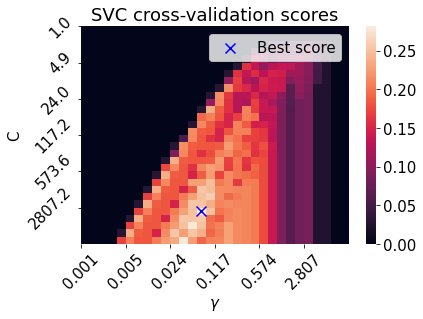

Best parameters:
 {'C': 2807.2162039411755, 'gamma': 0.06210169418915616}


In [81]:
svc=SVC(kernel="rbf",gamma=1,C=1)
param_grid={"gamma":np.logspace(-3,1,30),"C":np.logspace(0,4,30)}

gridsearch=GridSearchCV(svc,param_grid=param_grid,scoring="f1",cv=10)

gridsearch.fit(X_train,1-y_train)

scores=np.reshape(gridsearch.cv_results_["mean_test_score"],(30,30))
sns.heatmap(scores)
plt.scatter(np.where(gridsearch.param_grid["gamma"]==gridsearch.best_params_["gamma"])[0][0]+.5,
    np.where(gridsearch.param_grid["C"]==gridsearch.best_params_["C"])[0][0]+.5,marker="x",color="blue",s=100,label="Best score")

plt.xticks([0,5,10,15,20,25], np.round(gridsearch.param_grid["gamma"],3)[::5], rotation=45)  # Rotate labels if needed
plt.xlabel("$\gamma$")
plt.yticks([0,5,10,15,20,25], np.round(gridsearch.param_grid["C"],1)[::5], rotation=45)  # Rotate labels if needed
plt.ylabel("C")
plt.title("SVC cross-validation scores")
plt.legend()
plt.show()

print("Best parameters:\n",gridsearch.best_params_)

In [82]:
svc=SVC(kernel="rbf",gamma=gridsearch.best_params_["gamma"],C=gridsearch.best_params_["C"])
test_model(svc, X_train, y_train, X_test, y_test)
print("\n")
test_model(svc,X_train,1-y_train,X_test,1-y_test)

Train accuracy, precision, recall, F1: 0.949 0.941 1.000 0.970
Test accuracy, precision, recall, F1: 0.756 0.848 0.856 0.852
Confusion matrix: 
 [[ 7 16]
 [15 89]]


Train accuracy, precision, recall, F1: 0.949 1.000 0.722 0.839
Test accuracy, precision, recall, F1: 0.756 0.318 0.304 0.311
Confusion matrix: 
 [[89 15]
 [16  7]]


Izgleda da ni RBF-SVC nije polučio dobre rezultate... Svi isprobani modeli imaju F1-score nešto veći od 0.3 za invertirane klase $y$. Vidljivo je znatno pogoršanje modela izbacivanjem BWt(kg). Mislimo da uz ovakav dataset bolje rezultate nije ni moguće postići. Na kraju, poboljšanje modela sastojalo se u uklanjanju greške (ujedno i uzroka za vrlo visoke performanse iz članka) te pronalaženje najboljeg rješenja s onim što imamo. Za nekakvu drugačiju proceduru čišćenja podataka te čišći polazni dataset, sva tri pokušana modela i dalje mogu konkurirati za najboljeg, s obzirom vrlo slične iznose metrika.

# Regresija

Jedan zanimljivi eksperiment koji ćemo napraviti za kraj jest pokušaj klasifikacije regresijom. S obzirom na to da smo uklonili dvoznačnosti između težine i klase bebe, napravit ćemo predikcijske modele koji predviđaju značajku _BWt(Kg)_ i na temelju tih predikcija klasificirati bebu kao normalnu ili pothranjenu.

In [113]:
df_regression = df.copy()
X_reg=df_regression.drop(columns="BWt(kg)")
y_reg=df_regression["BWt(kg)"]

X_reg_train_1, X_reg_test_1, y_reg_train_1, y_reg_test_1 = train_test_split(X_reg, y_reg, test_size=0.30, random_state=42)

X_reg_train = X_reg_train_1.drop(columns="LNH").to_numpy()
X_reg_test = X_reg_test_1.drop(columns="LNH").to_numpy()
y_reg_train = y_reg_train_1.drop(columns="LNH").to_numpy()
y_reg_test = y_reg_test_1.drop(columns="LNH").to_numpy()

len(y_reg_train),len(y_reg_test)

(310, 133)

In [114]:
## funkcija analogna test_model za klasifikatore

def test_model_regression(regressor,X_train,y_train,X_test,y_test):
    regressor.fit(X_train,y_train)

    y_pred_train=regressor.predict(X_train)
    y_pred_test=regressor.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    print("Train MAE, MSE, R2: {:.3f} {:.3f} {:.3f}".format(mae_train, mse_train, r2_train))
    print("Test MAE, MSE, R2: {:.3f} {:.3f} {:.3f}".format(mae_test, mse_test, r2_test))

In [115]:
rfr = RandomForestRegressor(random_state=42)

test_model_regression(rfr, X_reg_train[:,], y_reg_train, X_reg_test[:,:], y_reg_test)

Train MAE, MSE, R2: 0.051 0.004 0.868
Test MAE, MSE, R2: 0.137 0.032 -0.018


Nakon treniranja regresorskog modela mapiramo njegove izlaze u **LNH** klase po već spomenutom pragu od 2.45 kg.

In [119]:
def regression_to_classification_converter(regressor, X_reg_train, X_reg_test, threshold_scaled):
    y_pred_train = regressor.predict(X_reg_train[:,])
    y_pred_test = regressor.predict(X_reg_test[:,])

    ## mapiranje u 0 ili 1 ovisno o 2.45 kg skaliranoj granici
    y_pred_train = np.where(y_pred_train <= threshold_scaled, 0, 1)
    y_pred_test = np.where(y_pred_test <= threshold_scaled, 0, 1)

    y_train = X_reg_train_1["LNH"].to_numpy()
    y_test = X_reg_test_1["LNH"].to_numpy()

    test_model(None, None, y_train, None, y_test, y_pred_train, y_pred_test)
    test_model(None, None, 1-y_train, None, 1-y_test, 1-y_pred_train, 1-y_pred_test)

U konačnici gledamo podudaraju li se kategorizirani izlazi regresora sa stvarnim vrijednostima **LNH**.

In [120]:
regression_to_classification_converter(rfr, X_reg_train, X_reg_test, threshold_scaled)

Train accuracy, precision, recall, F1: 0.926 0.924 0.988 0.955
Test accuracy, precision, recall, F1: 0.827 0.870 0.939 0.903
Confusion matrix: 
 [[  3  16]
 [  7 107]]
Train accuracy, precision, recall, F1: 0.926 0.938 0.692 0.796
Test accuracy, precision, recall, F1: 0.827 0.300 0.158 0.207
Confusion matrix: 
 [[107   7]
 [ 16   3]]


In [123]:
lr = LinearRegression()

test_model_regression(lr, X_reg_train[:,], y_reg_train, X_reg_test[:,:], y_reg_test)

regression_to_classification_converter(lr, X_reg_train, X_reg_test, threshold_scaled)

Train MAE, MSE, R2: 0.123 0.024 0.241
Test MAE, MSE, R2: 0.144 0.034 -0.074
Train accuracy, precision, recall, F1: 0.826 0.845 0.955 0.897
Test accuracy, precision, recall, F1: 0.805 0.867 0.912 0.889
Confusion matrix: 
 [[  3  16]
 [ 10 104]]
Train accuracy, precision, recall, F1: 0.826 0.667 0.338 0.449
Test accuracy, precision, recall, F1: 0.805 0.231 0.158 0.188
Confusion matrix: 
 [[104  10]
 [ 16   3]]


In [125]:
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

test_model_regression(svr, X_reg_train[:,], y_reg_train, X_reg_test[:,:], y_reg_test)

regression_to_classification_converter(svr, X_reg_train, X_reg_test, threshold_scaled)

Train MAE, MSE, R2: 0.124 0.024 0.242
Test MAE, MSE, R2: 0.140 0.032 -0.024
Train accuracy, precision, recall, F1: 0.816 0.822 0.980 0.894
Test accuracy, precision, recall, F1: 0.827 0.864 0.947 0.904
Confusion matrix: 
 [[  2  17]
 [  6 108]]
Train accuracy, precision, recall, F1: 0.816 0.722 0.200 0.313
Test accuracy, precision, recall, F1: 0.827 0.250 0.105 0.148
Confusion matrix: 
 [[108   6]
 [ 17   2]]


Kao što je vidljivo iz rezultata nekoliko regresora, nije došlo do poboljšanja u klasifikaciji kategorije težine djeteta.